# EnchanceNet - Implementing an image super resolution

### Imports

In [1]:
from models import generator_no_residual, generator_with_residual, discriminator
from utils import check_path_exists
from data_loader import load_images_with_truth
from loss_functions import perceptual_loss, perceptual_loss_16, perceptual_loss_19
from loss_functions import texture_loss_multi_layers, perceptual_plus_texture_loss, perceptual_16_plus_texture_loss
from visualizations import plot_images_for_compare, plot_images_for_compare_separate, compare_models
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

Using TensorFlow backend.


### Variables declaration

In [2]:
# Enable this flag if running on the laptop with smaller GPU
running_on_laptop=True
use_small_dataset = True
use_dataset_celeba=False

train_epochs = 300
train_batch_size = 32
test_image_index_to_show = [0, 1, 2, 3, 4, 5]

if running_on_laptop:
    train_epochs = 100
    train_batch_size = 8
    test_image_index_to_show = [0, 1, 2, 3, 4, 5]

In [3]:
# Define the dataset path
dataset = "MSCOCO"
if use_dataset_celeba:
    dataset = "celeba"

if not use_small_dataset:
    train_dataset_path = './data/{0}/train/*'.format(dataset)
    validation_dataset_path = './data/{0}/val/*'.format(dataset)
    test_dataset_path = './data/{0}/test/*'.format(dataset)
else:
    train_dataset_path = './data/{0}/train_small/*'.format(dataset)
    validation_dataset_path = './data/{0}/val_small/*'.format(dataset)
    test_dataset_path = './data/{0}/test_small/*'.format(dataset)

print(train_dataset_path)
print(validation_dataset_path)
print(test_dataset_path)

./data/MSCOCO/train_small/*
./data/MSCOCO/val_small/*
./data/MSCOCO/test_small/*


In [4]:
perceptual_loss_checkpint_path='./saved_models/weights.best.train.mscoco.pl.hdf5'
perceptual_loss_16_checkpoint_path='./saved_models/weights.best.train.mscoco.pl16.hdf5'
perceptual_loss_19_checkpoint_path='./saved_models/weights.best.train.mscoco.pl19.hdf5'
texture_loss_ml_checkpoint_path='./saved_models/weights.best.train.mscoco.tl_ml.hdf5'
texture_plus_perceptual_loss_checkpoint_path='./saved_models/weights.best.train.mscoco.tl_plus_pl.hdf5'
perceptual_16_plus_texture_loss_checkpoint_path='./saved_models/weights.best.train.mscoco.pl16_plus_tl.hdf5'

if use_dataset_celeba:
    perceptual_loss_checkpint_path='./saved_models/weights.best.train.celeba.pl.hdf5'
    perceptual_loss_16_checkpoint_path='./saved_models/weights.best.train.celeba.pl16.hdf5'
    perceptual_loss_19_checkpoint_path='./saved_models/weights.best.train.celeba.pl19.hdf5'
    texture_loss_ml_checkpoint_path='./saved_models/weights.best.train.celeba.tl_ml.hdf5'
    texture_plus_perceptual_loss_checkpoint_path='./saved_models/weights.best.train.celeba.tl_plus_pl.hdf5'
    perceptual_16_plus_texture_loss_checkpoint_path='./saved_models/weights.best.train.celeba.pl16_plus_tl.hdf5'

### Helper functions

#### Train the model

In [5]:
# NOTE: Some of the parameters are used from the global space
def model_train(model, optimizer, loss_function, checkpoint_path, verbose=2):
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, 
                               verbose=verbose, save_best_only=True)
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=verbose)

    model.fit(train_data_tensors, train_truth_tensors,
              validation_data=(validation_data_tensors, validation_truth_tensors),
              epochs=train_epochs, batch_size=train_batch_size, callbacks=[checkpointer, early_stopper], verbose=verbose)

#### Predict with the model

In [6]:
# NOTE: Some of the parameters are used from the global space
def model_predict(model, checkpoint_path):
    model.load_weights(checkpoint_path)

    print('Predicting...')
    predictions = model.predict(test_data_tensors)

    print('Plotting the results...')
    plot_images_for_compare_separate(test_data_tensors, predictions, test_truth_tensors, test_image_index_to_show)

    print('All done!')

In [7]:
# NOTE: Some of the parameters are used from the global space
def model_predict_2(model, checkpoint_path):
    model.load_weights(checkpoint_path)

    print('Predicting...')
    predictions = model.predict(test_data_tensors)

    print('Plotting the results...')
    plot_images_for_compare(test_data_tensors, predictions, test_truth_tensors, test_image_index_to_show)

    print('All done!')

#### Define the functions to load the images

For training, we use all color images in MSCOCO [31]
that have at least 384 pixels on the short side resulting in
roughly 200k images. All images are cropped centrally to a
square and then downsampled to 256×256 to reduce noise
and JPEG artifacts. During training, we fix the size of the
input ILR to 32×32. As the scale of objects in the MSCOCO
dataset is too small when downsampled to such a small size,
we downsample the 256×256 images by  and then crop
these to patches of size 32×32. After training the model
for any given scaling factor , the input to the fully convolutional
network at test time can be an image of arbitrary
dimensions w×h which is then upscaled to (w)×(h).

#### Read the input images

In [8]:
print('Loading train data:')
train_data, train_truth = load_images_with_truth(train_dataset_path, 4)
print('Loading validation data:')
validation_data, validation_truth = load_images_with_truth(validation_dataset_path, 4)
print('Loading test data:')
test_data, test_truth = load_images_with_truth(test_dataset_path, 4)

print("Train images: ", len(train_data))
print('Validation images: ', len(validation_data))
print("Test images: ", len(test_data))

train_data_tensors = train_data.astype('float32')/255
train_truth_tensors = train_truth.astype('float32')/255

validation_data_tensors = validation_data.astype('float32')/255
validation_truth_tensors = validation_truth.astype('float32')/255

test_data_tensors = test_data.astype('float32')/255
test_truth_tensors = test_truth.astype('float32')/255

Loading train data:


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 117.35it/s]


Loading validation data:


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 114.20it/s]


Loading test data:


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 105.49it/s]


Train images:  500
Validation images:  100
Test images:  10


### We need to create separate models even though that they are based on the same architecture. This is because we want to have new default parameters each time.

### Perceptual loss based on VGG19 (selected layers)

In [9]:
model = generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)

In [16]:
model_train(model=model, optimizer='adam', loss_function=perceptual_loss, checkpoint_path=perceptual_loss_checkpint_path, verbose=0)

Train on 500 samples, validate on 100 samples
Epoch 1/100
 - 22s - loss: 0.2950 - acc: 0.4729 - val_loss: 0.1758 - val_acc: 0.7094

Epoch 00001: val_loss improved from inf to 0.17580, saving model to ./saved_models/weights.best.train.mscoco.pl.hdf5
Epoch 2/100
 - 21s - loss: 0.1605 - acc: 0.6559 - val_loss: 0.1427 - val_acc: 0.6177

Epoch 00002: val_loss improved from 0.17580 to 0.14266, saving model to ./saved_models/weights.best.train.mscoco.pl.hdf5
Epoch 3/100
 - 21s - loss: 0.1404 - acc: 0.7135 - val_loss: 0.1345 - val_acc: 0.7732

Epoch 00003: val_loss improved from 0.14266 to 0.13445, saving model to ./saved_models/weights.best.train.mscoco.pl.hdf5
Epoch 4/100
 - 21s - loss: 0.1310 - acc: 0.7397 - val_loss: 0.1271 - val_acc: 0.7447

Epoch 00004: val_loss improved from 0.13445 to 0.12712, saving model to ./saved_models/weights.best.train.mscoco.pl.hdf5
Epoch 5/100
 - 20s - loss: 0.1259 - acc: 0.7616 - val_loss: 0.1228 - val_acc: 0.7823

Epoch 00005: val_loss improved from 0.12712 

Predicting...
Plotting the results...


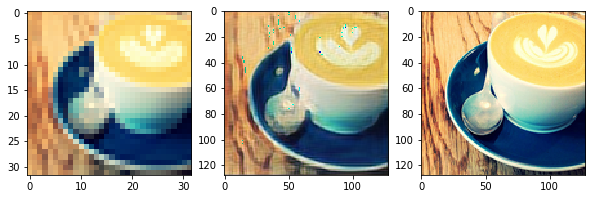

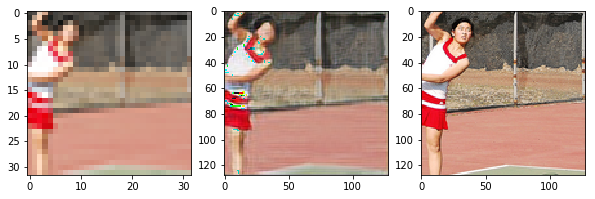

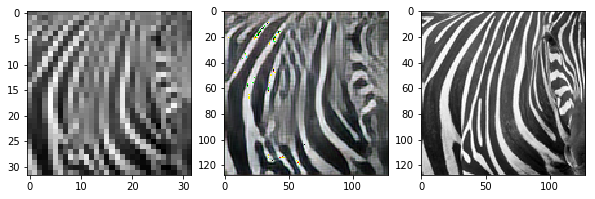

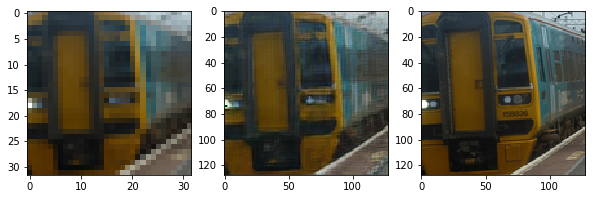

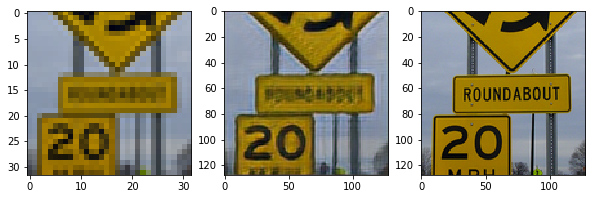

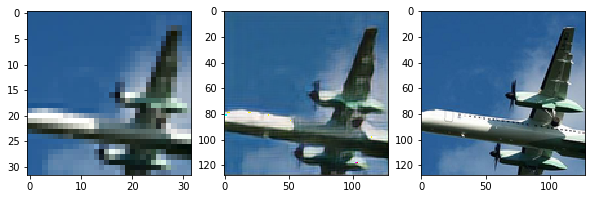

All done!


In [10]:
model_predict(model, perceptual_loss_checkpint_path)

### Peceptual loss based on VGG19 (block3_pool)

In [10]:
model19 = generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)

In [ ]:
model_train(model=model19, optimizer='adam', loss_function=perceptual_loss_19, checkpoint_path=perceptual_loss_19_checkpoint_path)

Predicting...
Plotting the results...


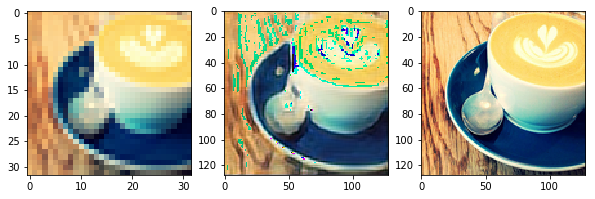

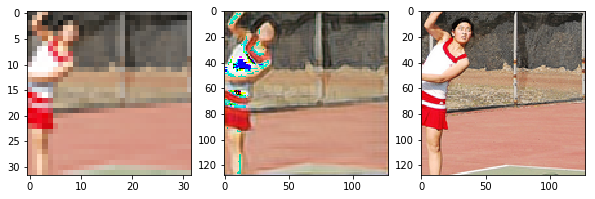

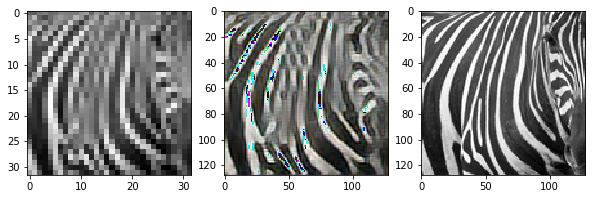

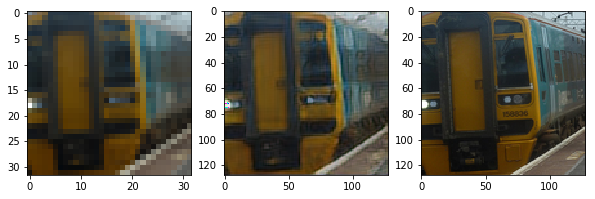

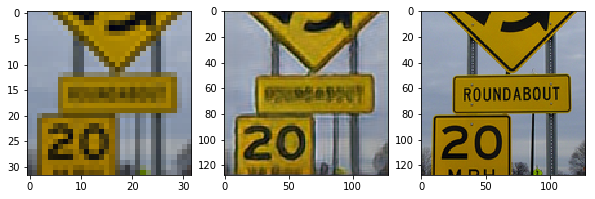

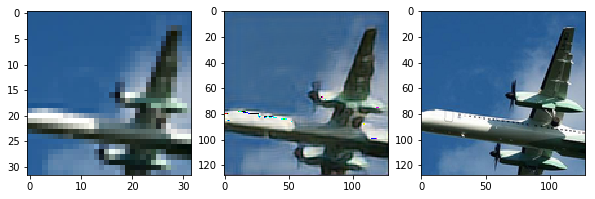

All done!


In [12]:
model_predict(model=model19, checkpoint_path=perceptual_loss_19_checkpoint_path)

### Peceptual loss based on VGG16 (block3_pool)

In [11]:
model16 = generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)

In [ ]:
model_train(model=model16, optimizer='adam', loss_function=perceptual_loss_16, checkpoint_path=perceptual_loss_16_checkpoint_path, verbose=0)

Predicting...
Plotting the results...


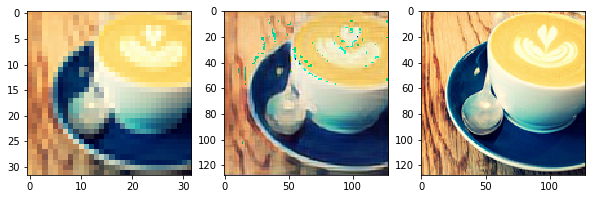

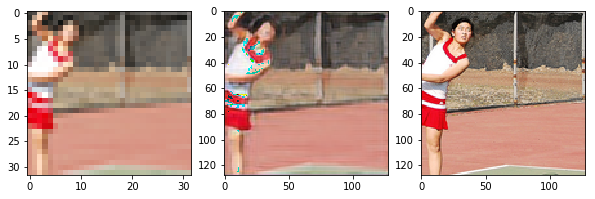

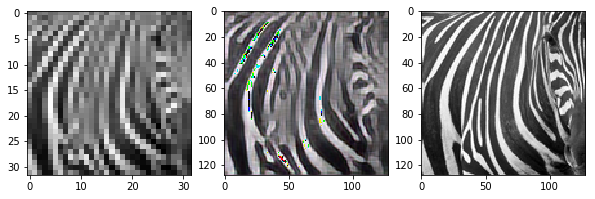

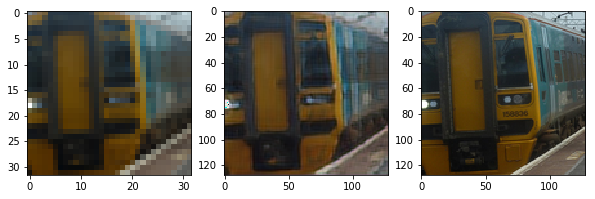

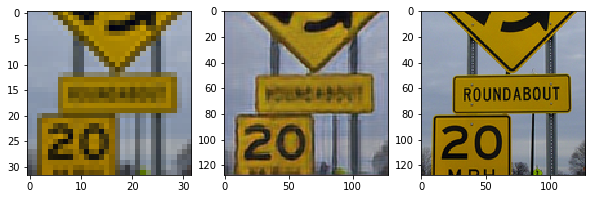

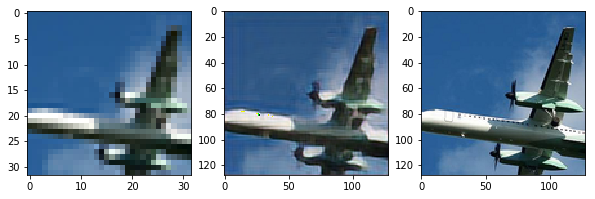

All done!


In [14]:
model_predict(model=model16, checkpoint_path=perceptual_loss_16_checkpoint_path)

### Texture loss (multi layers)

In [12]:
model_tl_ml = generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)

In [ ]:
model_train(model=model_tl_ml, optimizer='adam', loss_function=texture_loss_multi_layers, checkpoint_path=texture_loss_ml_checkpoint_path, verbose=0)

Predicting...
Plotting the results...


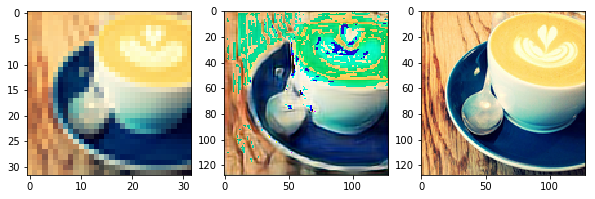

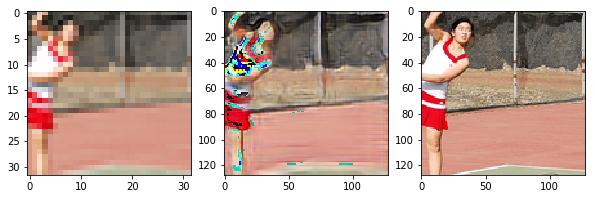

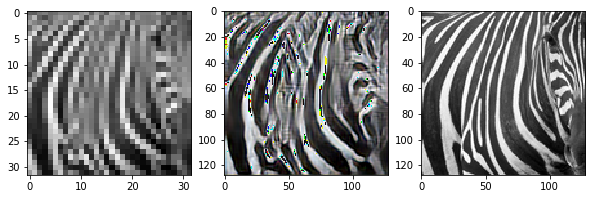

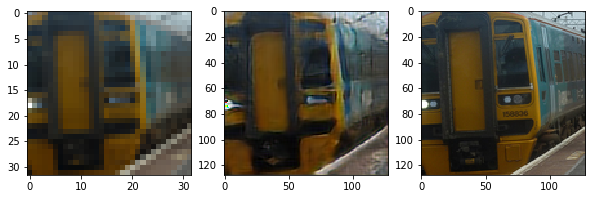

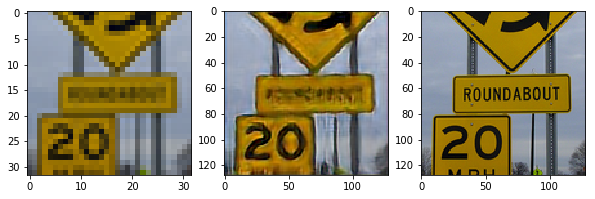

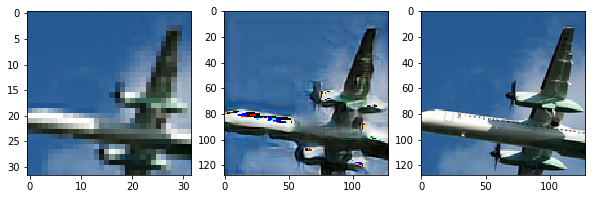

All done!


In [16]:
model_predict(model=model_tl_ml, checkpoint_path=texture_loss_ml_checkpoint_path)

### Texture loss plus perceptual loss

In [13]:
model_tl_plus_pl = generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)

In [12]:
model_train(model=model_tl_plus_pl, optimizer='adam', loss_function=perceptual_plus_texture_loss, checkpoint_path=texture_plus_perceptual_loss_checkpoint_path, verbose=0)

Predicting...
Plotting the results...


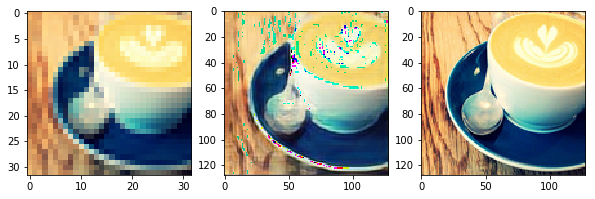

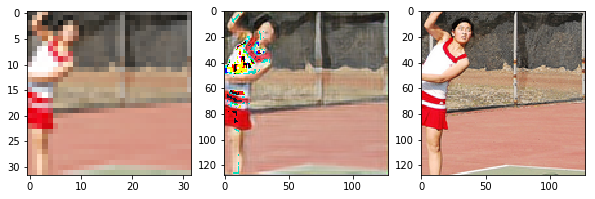

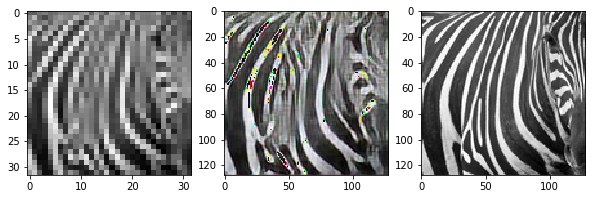

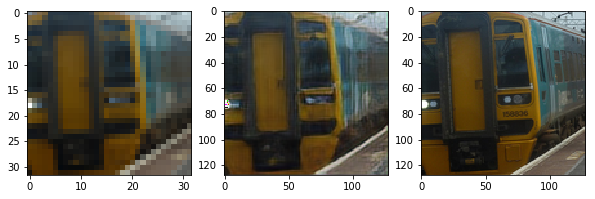

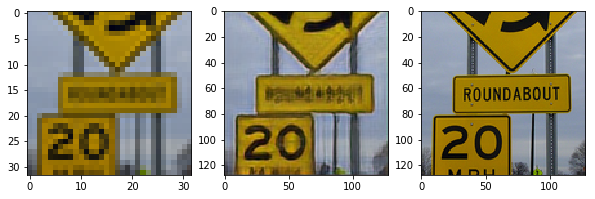

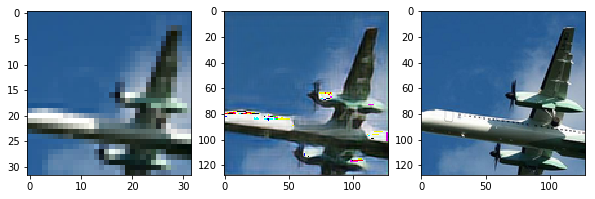

All done!


In [18]:
model_predict(model=model_tl_plus_pl, checkpoint_path=texture_plus_perceptual_loss_checkpoint_path)

### Peceptual loss 16 + texture loss

In [14]:
model_pl_16_plus_tl = generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)

In [13]:
model_train(model=model_pl_16_plus_tl, optimizer='adam', loss_function=perceptual_16_plus_texture_loss, checkpoint_path=perceptual_16_plus_texture_loss_checkpoint_path, verbose=0)

Predicting...
Plotting the results...


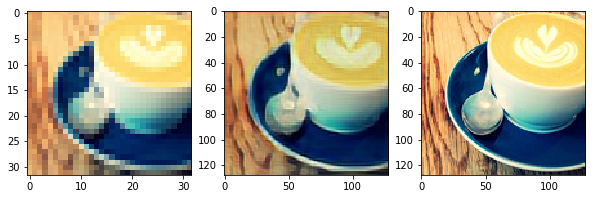

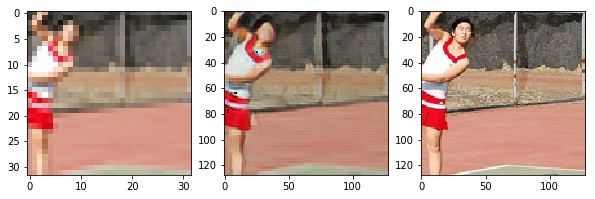

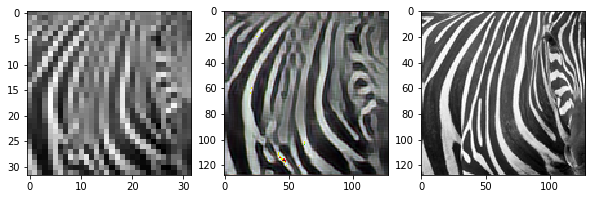

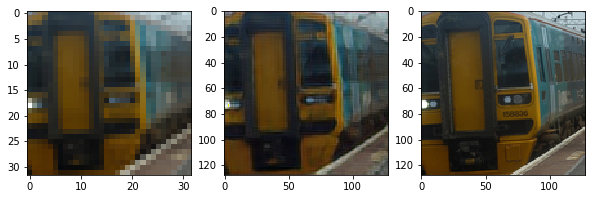

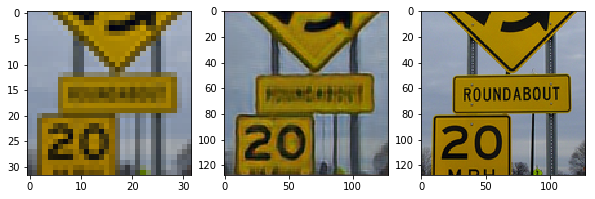

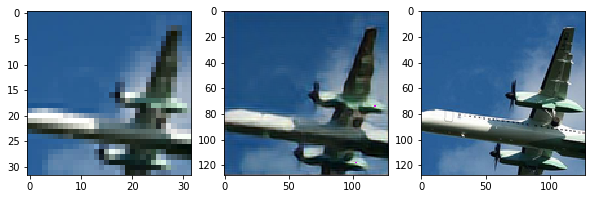

All done!


In [20]:
model_predict(model=model_pl_16_plus_tl, checkpoint_path=perceptual_16_plus_texture_loss_checkpoint_path)

## Compare all of the models at the same time

In [15]:
models_data = [{'name': "Perceptual loss", 'model': model, 'checkpoint': perceptual_loss_checkpint_path},
               {'name': "Perceptual VGG19", 'model': model19, 'checkpoint': perceptual_loss_19_checkpoint_path},
               {'name': "Perceptual VGG16", 'model': model16, 'checkpoint': perceptual_loss_16_checkpoint_path},
               {'name': "Texture loss", 'model': model_tl_ml, 'checkpoint': texture_loss_ml_checkpoint_path},
               {'name': "Perceptual VGG19 and Texture", 'model': model_tl_plus_pl, 'checkpoint': texture_plus_perceptual_loss_checkpoint_path},
               {'name': "Perceptual VGG16 and Texture", 'model': model_pl_16_plus_tl, 'checkpoint': perceptual_16_plus_texture_loss_checkpoint_path}]


Plotting the results...


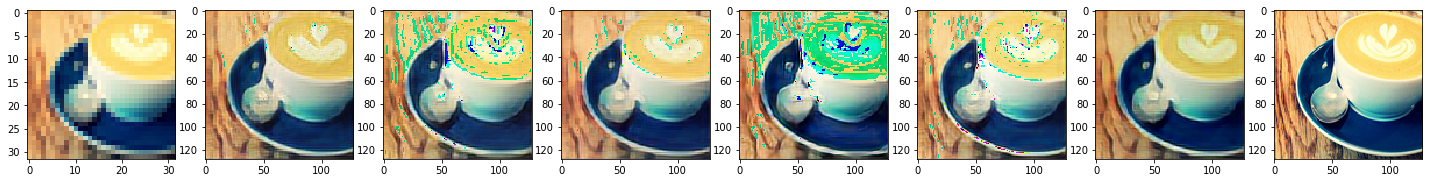

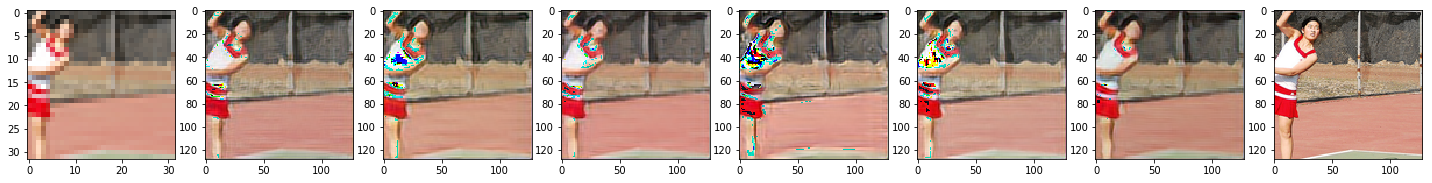

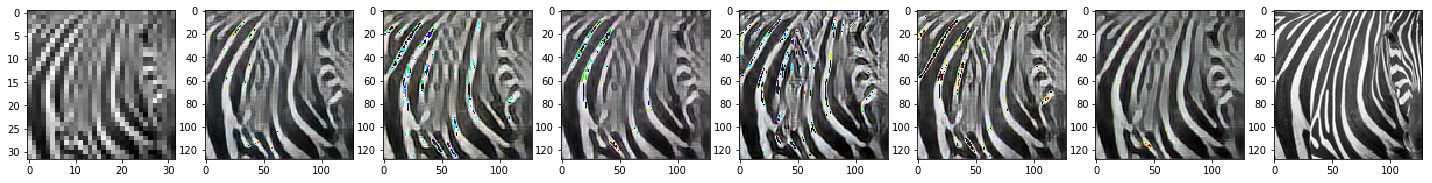

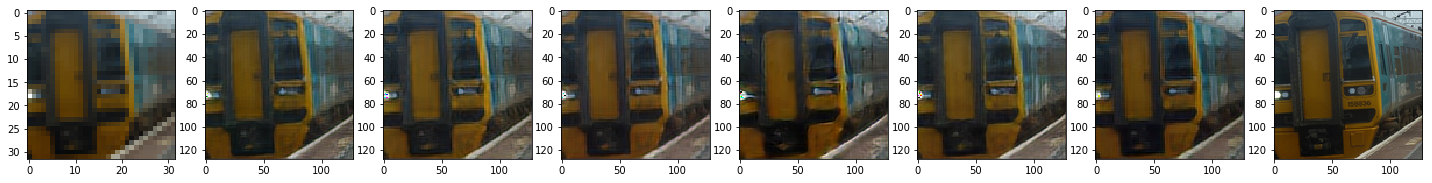

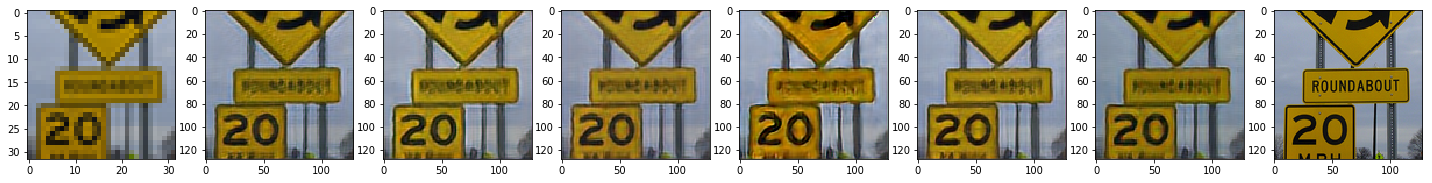

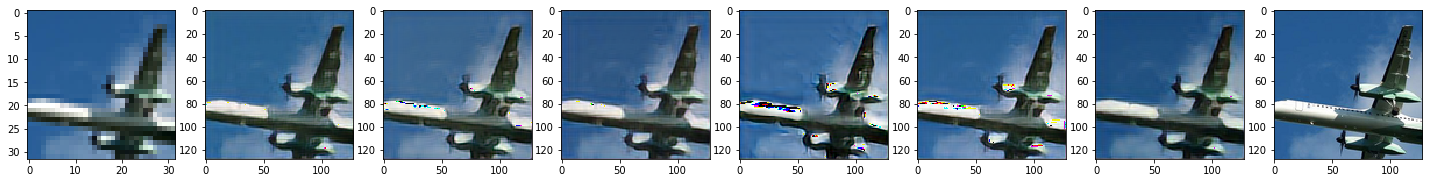

All done!


In [37]:
compare_models_test(test_data_tensors, test_truth_tensors, models_data, test_image_index_to_show, show_input=True)